## Problem 2: Finding the Optimal $k$ Using Leave-One-Out Cross-Validation

In this task, you will use the $K$-Nearest Neighbors (KNN) classifier to classify handwritten digits from the MNIST dataset. The goal is to determine:
1. The optimal number of neighbors ($k$) for the KNN classifier.
2. Evaluate the classifier’s performance using leave-one-out cross-validation (LOO CV).

You will:
1. Download and preprocess the MNIST dataset (use $10\%$ of the dataset for faster experimentation).
2. Implement leave-one-out cross-validation to evaluate the KNN classifier for various values of $k$.
3. Determine the optimal value of $k$ based on LOO CV results.

In [15]:
!pip install numpy==1.26 matplotlib scikit-learn umap-learn

In [16]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_openml
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import LeaveOneOut
from sklearn.metrics import accuracy_score
from sklearn.utils import resample
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import umap

import warnings
warnings.filterwarnings('ignore')

## Download the MNIST dataset

Note: This may take a moment 

In [17]:
mnist = fetch_openml('mnist_784', version=1)

## Preprocess the MNIST dataset

Normalize the pixel values (e.g., divide by $255$ to scale between $0$ and $1$)

In [18]:
X, y = mnist.data / 255.0, mnist.target.astype(int)  # normalize and convert labels to integer

Select a random $10\%$ subset of the dataset for faster experimentation

In [19]:
X_data, _, y_data, _ = train_test_split(X, y, test_size=0.9, random_state=42)
print(X_data.shape, y_data.shape)

(7000, 784) (7000,)


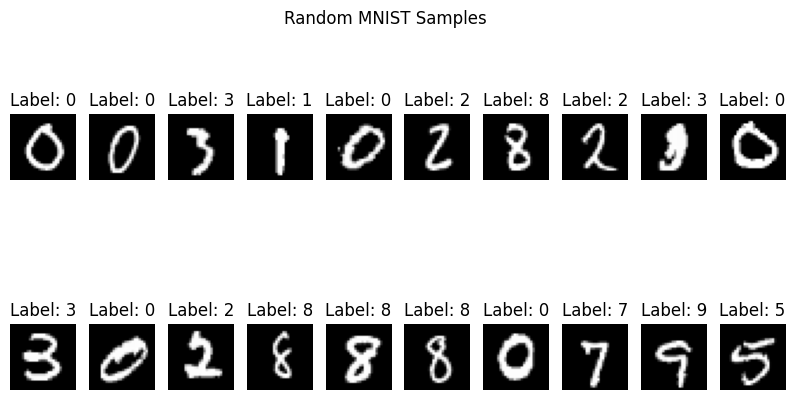

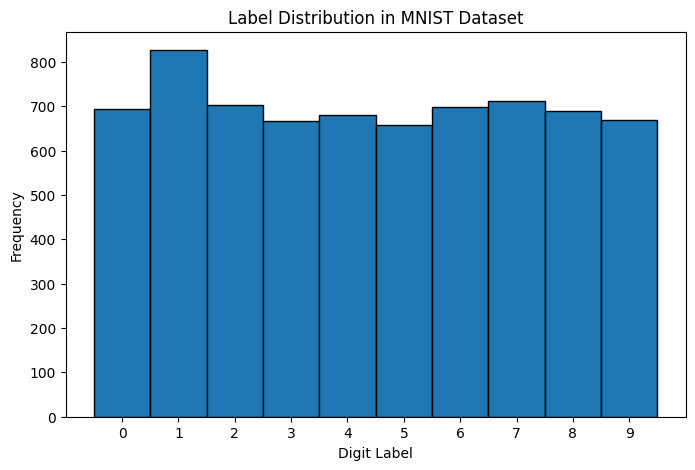

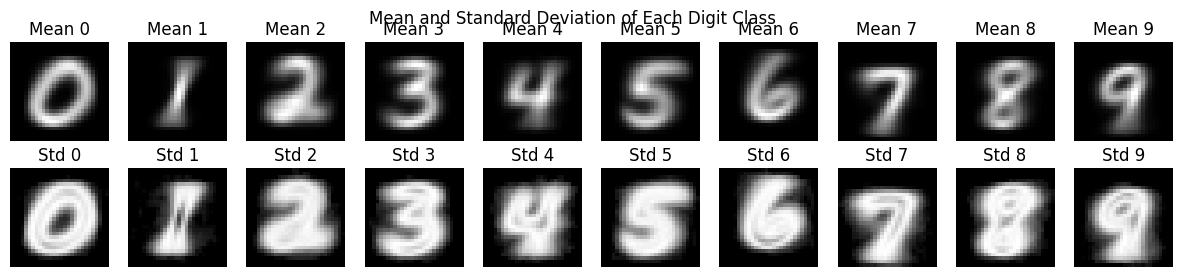

In [20]:
# function to plot a grid of random samples
def plot_random_samples(X_data, y_data, num_samples=20):
	indices = np.random.choice(len(X_data), num_samples, replace=False)
	images, labels = X_data[indices], y_data[indices]

	plt.figure(figsize=(10, 5))
	for i, (image, label) in enumerate(zip(images, labels)):
		plt.subplot(2, num_samples // 2, i + 1)
		plt.imshow(image.reshape(28, 28), cmap='gray')
		plt.title(f'Label: {label}')
		plt.axis('off')
	plt.suptitle("Random MNIST Samples")
	plt.show()

# function to plot label distribution
def plot_label_distribution(y_data):
	plt.figure(figsize=(8, 5))
	plt.hist(y_data, bins=np.arange(11) - 0.5, edgecolor='black')
	plt.xticks(range(10))
	plt.xlabel("Digit Label")
	plt.ylabel("Frequency")
	plt.title("Label Distribution in MNIST Dataset")
	plt.show()

# function to plot the mean and standard deviation of each digit class
def plot_mean_std(X_data, y_data):
	# Calculate the mean and std for each digit
	digit_stats = {i: [] for i in range(10)}
	for img, label in zip(X_data, y_data):
		digit_stats[label].append(img)

	means = []
	stds = []
	for i in range(10):
		digit_images = np.stack(digit_stats[i])
		mean_image = np.mean(digit_images, axis=0).reshape(28, 28)
		std_image = np.std(digit_images, axis=0).reshape(28, 28)
		means.append(mean_image)
		stds.append(std_image)

	# plotting means and standard deviations
	fig, axes = plt.subplots(2, 10, figsize=(15, 3))
	for i in range(10):
		axes[0, i].imshow(means[i], cmap='gray')
		axes[0, i].set_title(f"Mean {i}")
		axes[0, i].axis('off')
		axes[1, i].imshow(stds[i], cmap='gray')
		axes[1, i].set_title(f"Std {i}")
		axes[1, i].axis('off')

	plt.suptitle("Mean and Standard Deviation of Each Digit Class")
	plt.show()

plot_random_samples(np.array(X_data), np.array(y_data))
plot_label_distribution(np.array(y_data))
plot_mean_std(np.array(X_data), np.array(y_data))

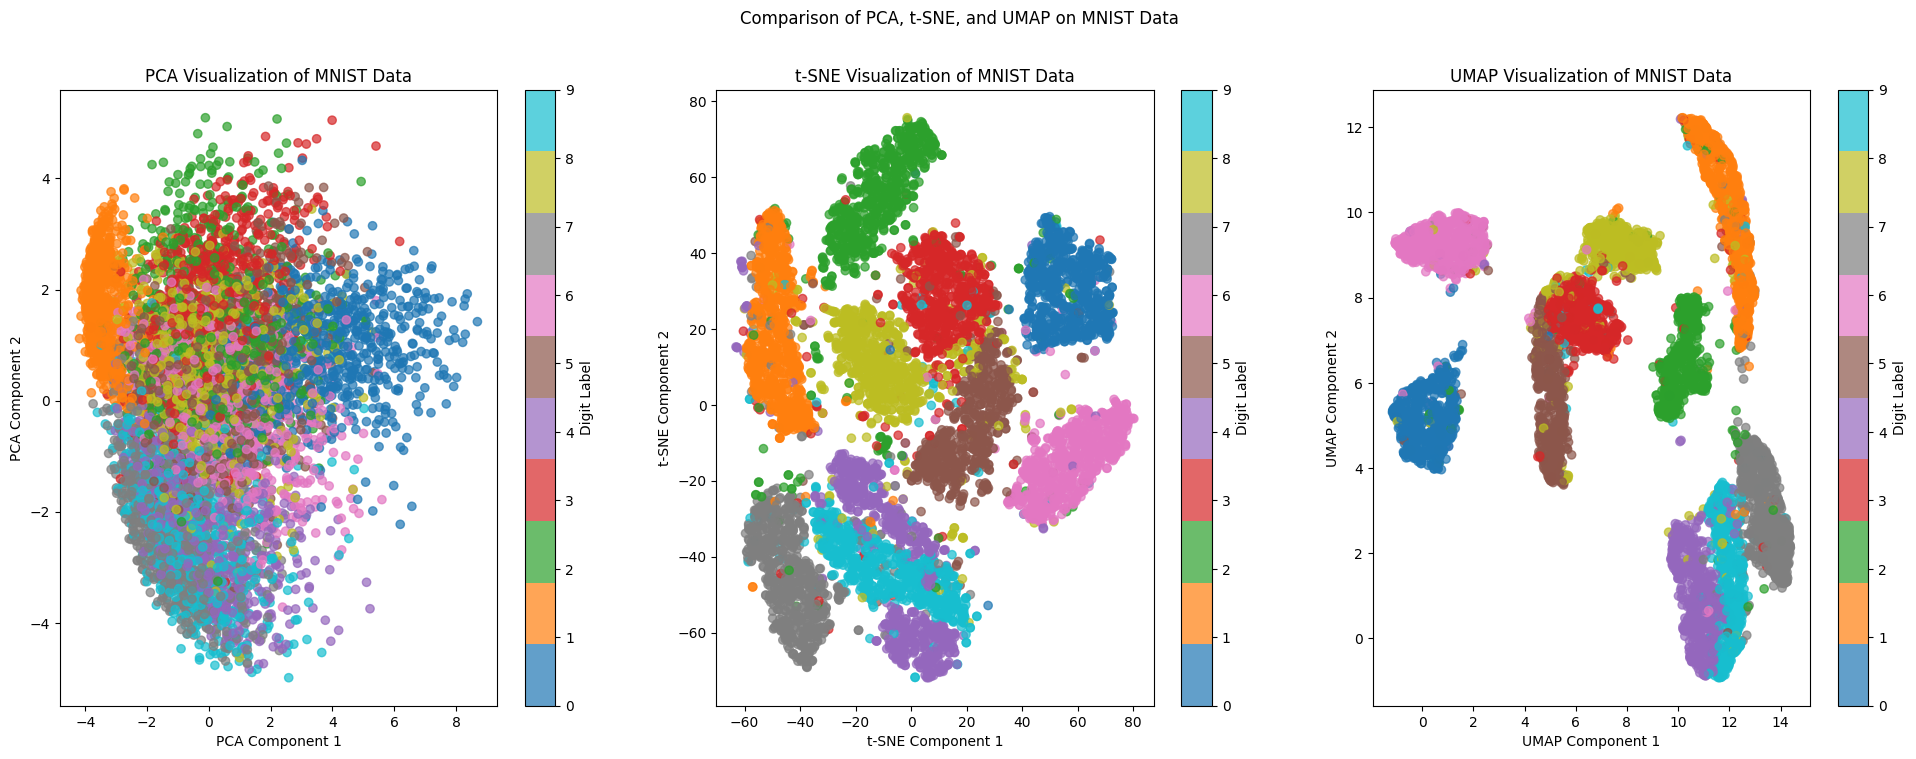

In [9]:
# dimensionality reduction using PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_data)

# dimensionality reduction using t-SNE
tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(X_data)

# dimensionality reduction using UMAP
umap_reducer = umap.UMAP(n_components=2, random_state=42)
X_umap = umap_reducer.fit_transform(X_data)

# plot the results
fig, ax = plt.subplots(1, 3, figsize=(24, 8))

# PCA Plot
scatter_pca = ax[0].scatter(X_pca[:, 0], X_pca[:, 1], c=y_data, cmap='tab10', alpha=0.7)
ax[0].set_title('PCA Visualization of MNIST Data')
ax[0].set_xlabel('PCA Component 1')
ax[0].set_ylabel('PCA Component 2')
plt.colorbar(scatter_pca, ax=ax[0], label='Digit Label')

# t-SNE Plot
scatter_tsne = ax[1].scatter(X_tsne[:, 0], X_tsne[:, 1], c=y_data, cmap='tab10', alpha=0.7)
ax[1].set_title('t-SNE Visualization of MNIST Data')
ax[1].set_xlabel('t-SNE Component 1')
ax[1].set_ylabel('t-SNE Component 2')
plt.colorbar(scatter_tsne, ax=ax[1], label='Digit Label')

# UMAP Plot
scatter_umap = ax[2].scatter(X_umap[:, 0], X_umap[:, 1], c=y_data, cmap='tab10', alpha=0.7)
ax[2].set_title('UMAP Visualization of MNIST Data')
ax[2].set_xlabel('UMAP Component 1')
ax[2].set_ylabel('UMAP Component 2')
plt.colorbar(scatter_umap, ax=ax[2], label='Digit Label')

plt.suptitle('Comparison of PCA, t-SNE, and UMAP on MNIST Data')
plt.show()

0.17159122339058253


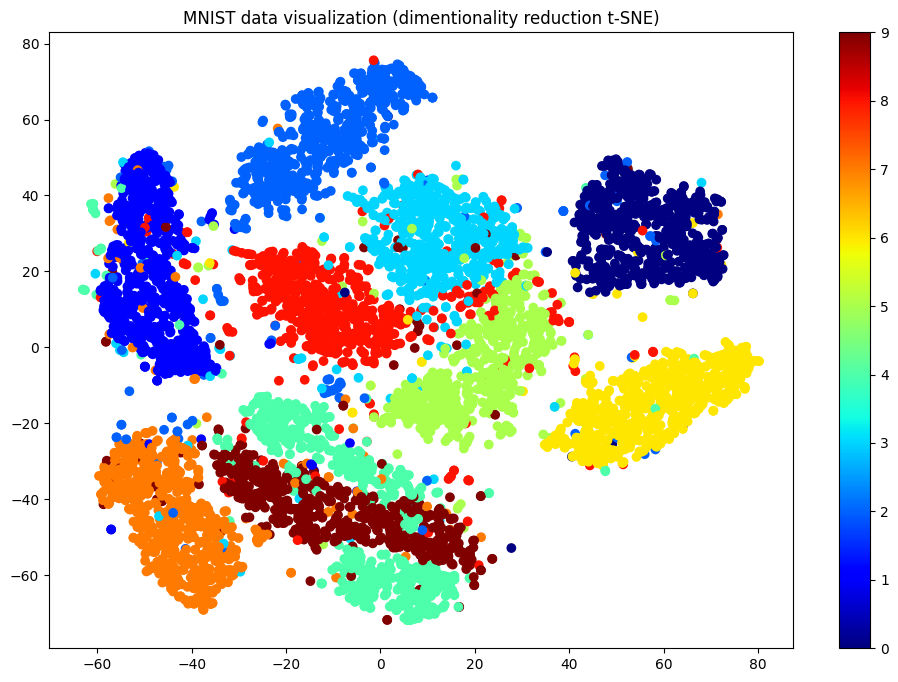

In [21]:
print(pca.explained_variance_ratio_.sum())

plt.figure(figsize=(12, 8))
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=y_data, cmap="jet")
plt.colorbar()
plt.title("MNIST data visualization (dimentionality reduction t-SNE)")
plt.show()

Overview of Expected Outcomes:
* PCA: Good for understanding overall variance in data, but clusters may overlap.
* t-SNE: Excellent at forming distinct clusters, often better for local structures.
* UMAP: Preserves local and global structures well, often balancing the benefits of PCA and t-SNE.

## KNN Classifier

Iterate over different values of $k$, specifically $k = 1, 2, ..., 10$

In [22]:
k_values = range(1, 11)  # values of k to test [1, 10]

## Leave-One-Out Cross-Validation

* For each value of $k$, perform LOO CV:
	* Train the KNN model on $n − 1$ data points, where $n$ is the total number of samples.
	* Test the model on the single data point left out.
	* Repeat this for all data points and compute the overall accuracy.

In [23]:
def loocv_knn(X_data, y_data, k_values):
	results = {}
	results2 = {}

	loo = LeaveOneOut()

	for k in k_values:
		correct_predictions = 0
		knn = KNeighborsClassifier(n_neighbors=k)
		
		accuracies = []

		# perform LOO CV
		for train_index, test_index in loo.split(X_data):
			X_train, X_test = X_data.iloc[train_index], X_data.iloc[test_index]
			y_train, y_test = y_data.iloc[train_index], y_data.iloc[test_index]
			
			knn.fit(X_train, y_train)
			y_pred = knn.predict(X_test)
			
			# check if the prediction is correct
			if y_pred == np.array(y_test):
				correct_predictions += 1
		
			accuracy = accuracy_score(y_test, y_pred)
			accuracies.append(accuracy)

		mean_accuracy = correct_predictions / X_data.shape[0]
		results[k] = mean_accuracy
		results2[k] = np.mean(accuracies)

	for k, mean_accuracy in results.items():
		print(f'Mean accuracy for k={k}: {mean_accuracy}')

	for k, mean_accuracy in results2.items():
		print(f'Mean accuracy for k={k}: {mean_accuracy}')

	return results

There are some other approaches to implement loo cv like:
* `X_train, X_test = np.concatenate((X_data[:i], X_data[i+1:])), X_data[i:i+1]`

In [24]:
results = loocv_knn(X_data, y_data, k_values)

Mean accuracy for k=1: 0.9408571428571428
Mean accuracy for k=2: 0.9281428571428572
Mean accuracy for k=3: 0.9414285714285714
Mean accuracy for k=4: 0.9385714285714286
Mean accuracy for k=5: 0.9401428571428572
Mean accuracy for k=6: 0.9384285714285714
Mean accuracy for k=7: 0.9375714285714286
Mean accuracy for k=8: 0.9352857142857143
Mean accuracy for k=9: 0.9351428571428572
Mean accuracy for k=10: 0.934
Mean accuracy for k=1: 0.9408571428571428
Mean accuracy for k=2: 0.9281428571428572
Mean accuracy for k=3: 0.9414285714285714
Mean accuracy for k=4: 0.9385714285714286
Mean accuracy for k=5: 0.9401428571428572
Mean accuracy for k=6: 0.9384285714285714
Mean accuracy for k=7: 0.9375714285714286
Mean accuracy for k=8: 0.9352857142857143
Mean accuracy for k=9: 0.9351428571428572
Mean accuracy for k=10: 0.934


## Determine the Optimal $k$

* Calculate the accuracy for each value of $k$.
* Determine the value of $k$ with the highest accuracy.

In [25]:
optimal_k = max(results, key=results.get)

print(f"The optimal number of neighbors (k) is: {optimal_k} with an accuracy of {results[optimal_k]}")

The optimal number of neighbors (k) is: 3 with an accuracy of 0.9414285714285714


## Plots

* Plot the accuracy for each value of $k$ based on the LOO CV results.

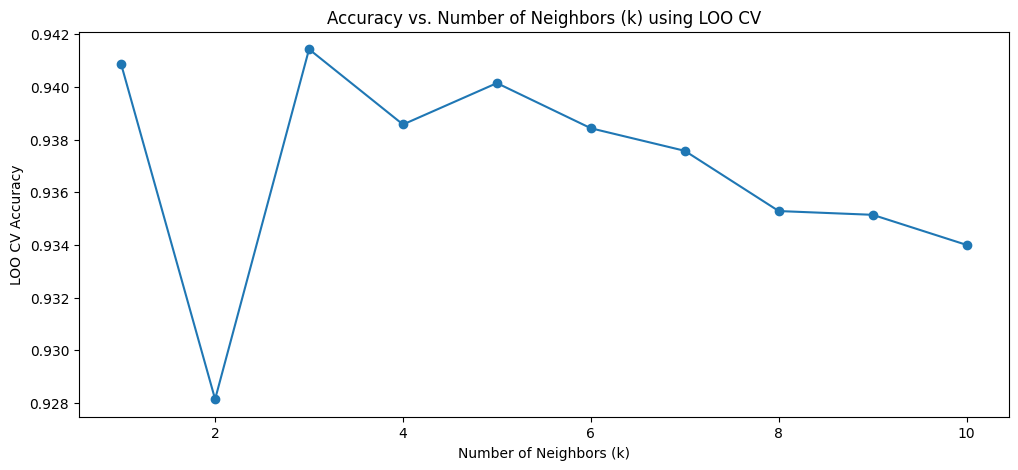

In [26]:
plt.figure(figsize=(12, 5))
plt.plot(list(results.keys()),list(results.values()), marker='o')
plt.xlabel('Number of Neighbors (k)')
plt.ylabel('LOO CV Accuracy')
plt.title('Accuracy vs. Number of Neighbors (k) using LOO CV')
plt.show()